In [1]:
from pathlib import Path

import torch
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, Lasso, Ridge
from sklearn.metrics import roc_curve, auc, accuracy_score, RocCurveDisplay
from matplotlib.pyplot import subplots


## Static train/test/validation split

Scikit-learn classifier results with a static 9:1:1 train:test:validation split.

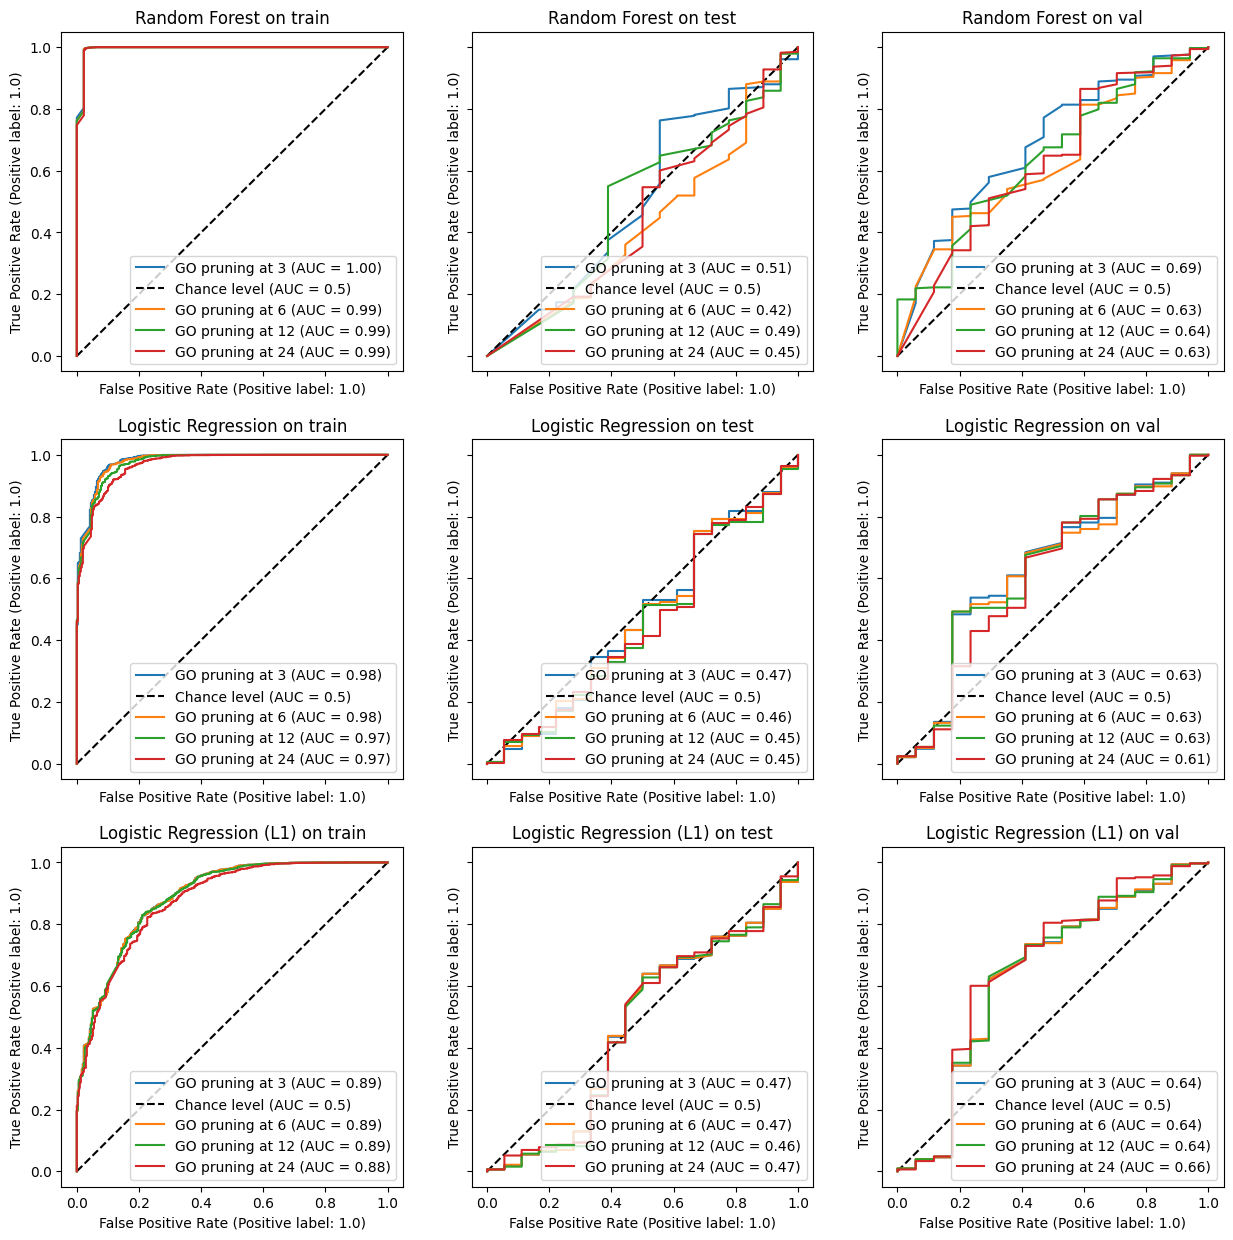

In [19]:
models = [
    ('Random Forest', RandomForestClassifier),
    ('Logistic Regression', LogisticRegression),
    ('Logistic Regression (L1)', lambda: LogisticRegression(penalty='l1', solver='liblinear'))
]
sets = ['train', 'test', 'val']

fig, ax = subplots(nrows=len(models), ncols=len(sets), sharex=True, sharey=True, squeeze=False, figsize=(15,15))

first = True
for data, pruning in ((torch.load(Path(f'../data/cpg0016_v3_{pruning}.pt')), pruning) for pruning in [3,6,12,24]):
    y = (data.y+1)/2
    for row, (name, model_generator) in enumerate(models):
        model = model_generator()
        model.fit(data.x[data.train_mask, :], y[data.train_mask,0])

        for col, set_prefix in enumerate(sets):
            mask = data[f'{set_prefix}_mask']
            RocCurveDisplay.from_estimator(model, data.x[mask, :], y[mask, 0], name=f'GO pruning at {pruning}', plot_chance_level=first, ax=ax[row, col])
            if first:
                ax[row, col].set_title(f'{name} on {set_prefix}')

    first = False

## Cross-validation

10-fold cross-validation results on the same data

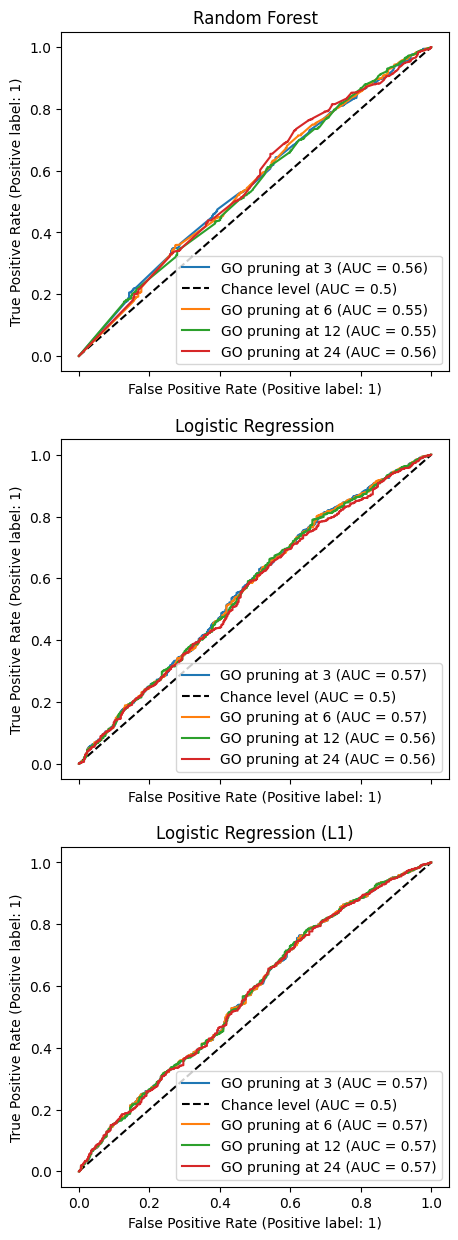

In [24]:
from sklearn.model_selection import StratifiedKFold, cross_val_predict

cv = StratifiedKFold(n_splits=10, random_state=20240131, shuffle=True)

fig, ax = subplots(nrows=len(models), ncols=1, sharex=True, sharey=True, squeeze=False, figsize=(5,15))

col = 0
first = True
for data, pruning in ((torch.load(Path(f'../data/cpg0016_v3_{pruning}.pt')), pruning) for pruning in [3,6,12,24]):
    labeled_mask = data.train_mask | data.test_mask | data.val_mask
    y = ((data.y+1)/2)[labeled_mask, 0]
    x = data.x[labeled_mask, :]

    for row, (name, model_generator) in enumerate(models):
        probs = cross_val_predict(model_generator(), x, y, cv=cv, method='predict_proba')[:, 1]
        RocCurveDisplay.from_predictions(y, probs, name=f'GO pruning at {pruning}', plot_chance_level=first, ax=ax[row, col])
        if first:
            ax[row, col].set_title(f'{name}')

    first = False